### Exploratory analysis of the post study questionnaire responses

In [69]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.stats as sp 
import json 

np.random.seed(42)
sns.set_style('ticks')
sns.set_palette('colorblind')

likert_mapping = {
    'order': ['strongly disagree',  'disagree', 'neutral', 'agree', 'strongly agree'],
    'formatted': ['Strongly Disagree', 'Disagree', 'Neurtal', 'Agree', 'Strongly Agree'],
    'numerical': {
        'strongly disagree': 1, 'disagree': 2, 'neutral': 3, 'agree': 4, 'strongly agree': 5
    }
}
question_mappings = json.load(open('../data/question_mappings.json', 'r'))

In [70]:
post_study = pd.read_csv('../data/post-study.csv')
post_study.head()

,user_id,user_created,part,choice_satisfaction_one,choice_satisfaction_two,choice_satisfaction_three,choice_satisfaction_four,choice_satisfaction_five,choice_satisfaction_six,choice_satisfaction_seven,...,intention,relevant_one,relevant_two,relevant_three,relevant_four,trust_one,trust_two,trust_three,trust_four,trust_five
0,62b14681-8d4a-44b5-a201-942bba9b4bd8,2022-07-22 13:45:02.013320,part_one,agree,neutral,neutral,agree,neutral,neutral,disagree,...,agree,agree,disagree,agree,agree,disagree,neutral,strongly agree,disagree,agree
1,62b14681-8d4a-44b5-a201-942bba9b4bd8,2022-07-22 13:45:02.013320,part_two,neutral,disagree,neutral,disagree,neutral,disagree,disagree,...,agree,agree,disagree,agree,agree,disagree,neutral,strongly agree,disagree,agree
2,09cf0e31-cf99-47f3-906f-8da336f23f73,2022-07-22 13:45:43.294777,part_one,neutral,neutral,neutral,agree,strongly agree,agree,disagree,...,disagree,disagree,disagree,strongly disagree,strongly disagree,disagree,disagree,agree,disagree,agree
3,09cf0e31-cf99-47f3-906f-8da336f23f73,2022-07-22 13:45:43.294777,part_two,neutral,neutral,neutral,strongly agree,strongly agree,agree,disagree,...,disagree,disagree,disagree,strongly disagree,strongly disagree,disagree,disagree,agree,disagree,agree
4,27405dfe-adee-47e8-b002-818e61c5c552,2022-07-22 14:36:52.999452,part_one,agree,agree,strongly agree,strongly agree,agree,neutral,disagree,...,agree,disagree,disagree,disagree,disagree,strongly disagree,agree,agree,disagree,strongly agree


In [71]:
# literally no idea what happened here
post_study = post_study.rename(columns = {'choice_satisfaction_three.1': 'perceived_effectiveness_three'})
post_study.columns

Index(['user_id', 'user_created', 'part', 'choice_satisfaction_one',
       'choice_satisfaction_two', 'choice_satisfaction_three',
       'choice_satisfaction_four', 'choice_satisfaction_five',
       'choice_satisfaction_six', 'choice_satisfaction_seven',
       'choice_satisfaction_eight', 'choice_satisfaction_nine',
       'perceived_effectiveness_one', 'perceived_effectiveness_two',
       'perceived_effectiveness_three', 'perceived_effectiveness_four',
       'perceived_effectiveness_five', 'perceived_effectiveness_six',
       'perceived_effectiveness_seven', 'perceived_effectiveness_eight',
       'perceived_effectiveness_nine', 'perceived_effectiveness_ten',
       'perceived_quality_one', 'perceived_quality_two',
       'perceived_quality_three', 'perceived_quality_four',
       'perceived_quality_five', 'perceived_quality_six', 'test_awareness_one',
       'test_awareness_two', 'intention', 'relevant_one', 'relevant_two',
       'relevant_three', 'relevant_four', 'trust_one'

In [72]:
questions = {
    q: [x for x in post_study.columns if q in x]
    for q in ['satisfaction', 'effectiveness', 'quality', 'awareness', 'intention', 'relevant', 'trust']
}

In [73]:
users = pd.read_csv('../data/users.csv')
users.columns

Index(['user_id', 'user_created', 'consent', 'art_knowledge', 'museum_visits',
       'view_collections', 'physical_visits', 'condition', 'order', 'age',
       'gender', 'education', 'work', 'disability',
       'distraction_task_timestamp'],
      dtype='object')

In [74]:
"""
This is probably incredibly hacky but it's a way of getting the proper data into
the correct format for later plotting.
"""
import itertools

subdata = []
required_columns = list(itertools.chain.from_iterable([qs for qs in questions.values()]))

for user in users['user_id'].unique():
    if user in post_study['user_id'].unique():
        # which part did the user see the model condition?
        if users[users.user_id == user]['order'].item() == 'model':
            responses = {
                q: post_study[(post_study.user_id == user) & (post_study.part == 'part_one')][q].tolist()[0]
                for q in required_columns
            }
            responses['condition'] = 'model'
            responses['user_id'] = user 
            responses['model_type'] = users[users.user_id == user]['condition'].item()
            responses['part'] = 'part_one'
            subdata.append(responses)
            which = 'part_one'
        else:
            responses = {
                q: post_study[(post_study.user_id == user) & (post_study.part == 'part_two')][q].tolist()[0]
                for q in required_columns
            }
            responses['condition'] = 'random'
            responses['user_id'] = user 
            responses['model_type'] = 'random'
            responses['part'] = 'part_two'
            subdata.append(responses)

        if which == 'part_one':
            responses = {
                q: post_study[(post_study.user_id == user) & (post_study.part == 'part_two')][q].tolist()[0]
                for q in required_columns
            }
            responses['condition'] = 'random'
            responses['user_id'] = user 
            responses['model_type'] = 'random'
            responses['part'] = 'part_two'
            subdata.append(responses)
        else:
            responses = {
                q: post_study[(post_study.user_id == user) & (post_study.part == 'part_one')][q].tolist()[0]
                for q in required_columns
            }
            responses['condition'] = 'model'
            responses['user_id'] = user 
            responses['model_type'] = users[users.user_id == user]['condition'].item()
            responses['part'] = 'part_one'
            subdata.append(responses)

data_formatted = pd.DataFrame(subdata)
data_formatted.head()

,choice_satisfaction_one,choice_satisfaction_two,choice_satisfaction_three,choice_satisfaction_four,choice_satisfaction_five,choice_satisfaction_six,choice_satisfaction_seven,choice_satisfaction_eight,choice_satisfaction_nine,perceived_effectiveness_one,...,relevant_four,trust_one,trust_two,trust_three,trust_four,trust_five,condition,user_id,model_type,part
0,agree,neutral,neutral,agree,neutral,neutral,disagree,neutral,agree,agree,...,agree,disagree,neutral,strongly agree,disagree,agree,model,62b14681-8d4a-44b5-a201-942bba9b4bd8,image,part_one
1,neutral,disagree,neutral,disagree,neutral,disagree,disagree,strongly disagree,agree,agree,...,agree,disagree,neutral,strongly agree,disagree,agree,random,62b14681-8d4a-44b5-a201-942bba9b4bd8,random,part_two
2,neutral,neutral,neutral,agree,strongly agree,agree,disagree,disagree,agree,neutral,...,strongly disagree,disagree,disagree,agree,disagree,agree,model,09cf0e31-cf99-47f3-906f-8da336f23f73,meta,part_one
3,neutral,neutral,neutral,strongly agree,strongly agree,agree,disagree,disagree,disagree,disagree,...,strongly disagree,disagree,disagree,agree,disagree,agree,random,09cf0e31-cf99-47f3-906f-8da336f23f73,random,part_two
4,agree,agree,strongly agree,strongly agree,agree,neutral,disagree,agree,agree,agree,...,disagree,strongly disagree,agree,agree,disagree,strongly agree,model,27405dfe-adee-47e8-b002-818e61c5c552,image,part_one


In [75]:
import os 
if not os.path.isfile('../data/user_condition_mapping.csv'):
    data_formatted.to_csv('../data/user_condition_mapping.csv', index = False)

In [76]:
data_formatted.columns

Index(['choice_satisfaction_one', 'choice_satisfaction_two',
       'choice_satisfaction_three', 'choice_satisfaction_four',
       'choice_satisfaction_five', 'choice_satisfaction_six',
       'choice_satisfaction_seven', 'choice_satisfaction_eight',
       'choice_satisfaction_nine', 'perceived_effectiveness_one',
       'perceived_effectiveness_two', 'perceived_effectiveness_three',
       'perceived_effectiveness_four', 'perceived_effectiveness_five',
       'perceived_effectiveness_six', 'perceived_effectiveness_seven',
       'perceived_effectiveness_eight', 'perceived_effectiveness_nine',
       'perceived_effectiveness_ten', 'perceived_quality_one',
       'perceived_quality_two', 'perceived_quality_three',
       'perceived_quality_four', 'perceived_quality_five',
       'perceived_quality_six', 'test_awareness_one', 'test_awareness_two',
       'intention', 'relevant_one', 'relevant_two', 'relevant_three',
       'relevant_four', 'trust_one', 'trust_two', 'trust_three', 'trus

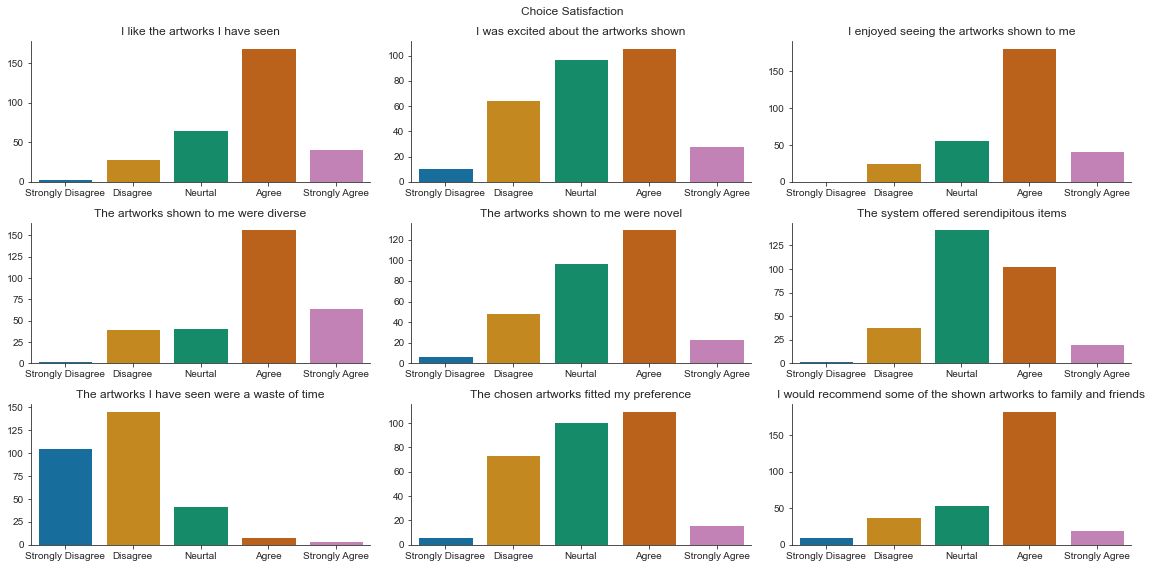

In [77]:
# Create a larger multi-plot for the bigger question groupings, i.e., satisfaction (5x2)
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (16, 8))
axes = axes.ravel()

for ax, q in zip(axes, questions['satisfaction']):
    p = sns.countplot(
        x = q, data = post_study, ax = ax, 
        order = likert_mapping['order']
    )
    p.set(
        ylabel = '',
        xlabel = '',
        xticklabels = likert_mapping['formatted'],
        title = question_mappings[q]
    )

fig.suptitle('Choice Satisfaction')
sns.despine()
plt.tight_layout()
plt.savefig('../plots/post-study/choice_satisfaction.png', dpi = 300)
# plt.show()

In [78]:
data_formatted.columns

Index(['choice_satisfaction_one', 'choice_satisfaction_two',
       'choice_satisfaction_three', 'choice_satisfaction_four',
       'choice_satisfaction_five', 'choice_satisfaction_six',
       'choice_satisfaction_seven', 'choice_satisfaction_eight',
       'choice_satisfaction_nine', 'perceived_effectiveness_one',
       'perceived_effectiveness_two', 'perceived_effectiveness_three',
       'perceived_effectiveness_four', 'perceived_effectiveness_five',
       'perceived_effectiveness_six', 'perceived_effectiveness_seven',
       'perceived_effectiveness_eight', 'perceived_effectiveness_nine',
       'perceived_effectiveness_ten', 'perceived_quality_one',
       'perceived_quality_two', 'perceived_quality_three',
       'perceived_quality_four', 'perceived_quality_five',
       'perceived_quality_six', 'test_awareness_one', 'test_awareness_two',
       'intention', 'relevant_one', 'relevant_two', 'relevant_three',
       'relevant_four', 'trust_one', 'trust_two', 'trust_three', 'trus

##### Choice Satisifaction by recommendation type

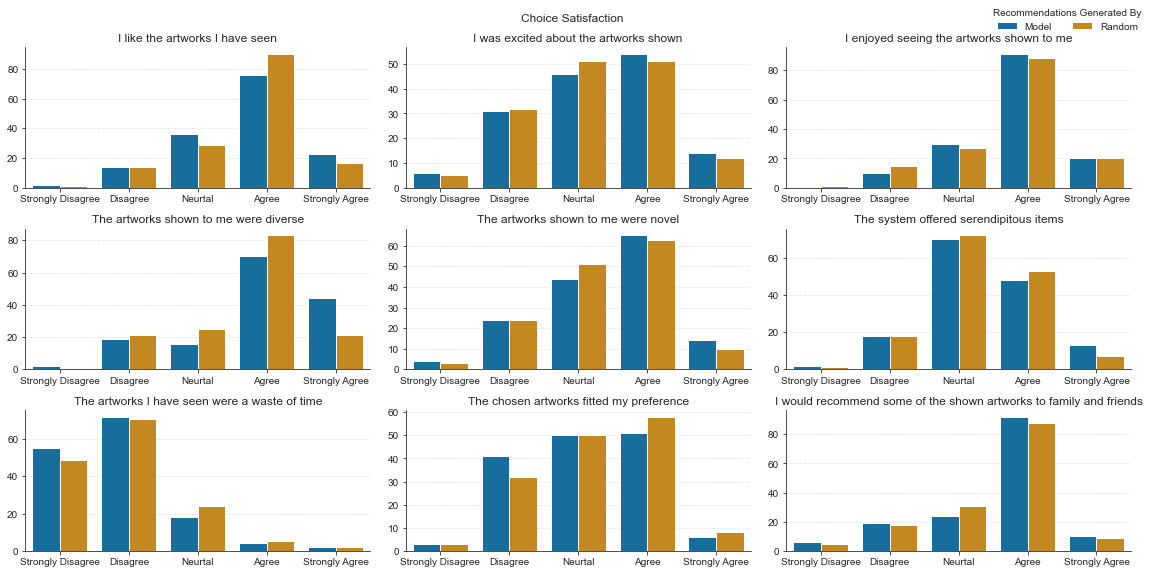

In [79]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (16, 8))
axes = axes.ravel()

for ax, q in zip(axes, questions['satisfaction']):
    p = sns.countplot(
        x = q, 
        data = data_formatted,
        ax = ax, 
        order = likert_mapping['order'],
        hue = 'condition'
    )
    p.set(
        ylabel = '',
        xlabel = '',
        xticklabels = likert_mapping['formatted'],
        title = question_mappings[q]
    )
    p.legend_.remove()
    p.yaxis.grid(True, alpha = 0.5, linestyle = 'dashed')

handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, ['Model', 'Random'], ncol = 2, title = 'Recommendations Generated By', frameon = False)

fig.suptitle('Choice Satisfaction')
sns.despine()
plt.tight_layout()
# plt.show()
plt.savefig('../plots/post-study/choice_satisfaction_by_recs.png', dpi = 300)

##### Perceived effectiveness by recommendation type

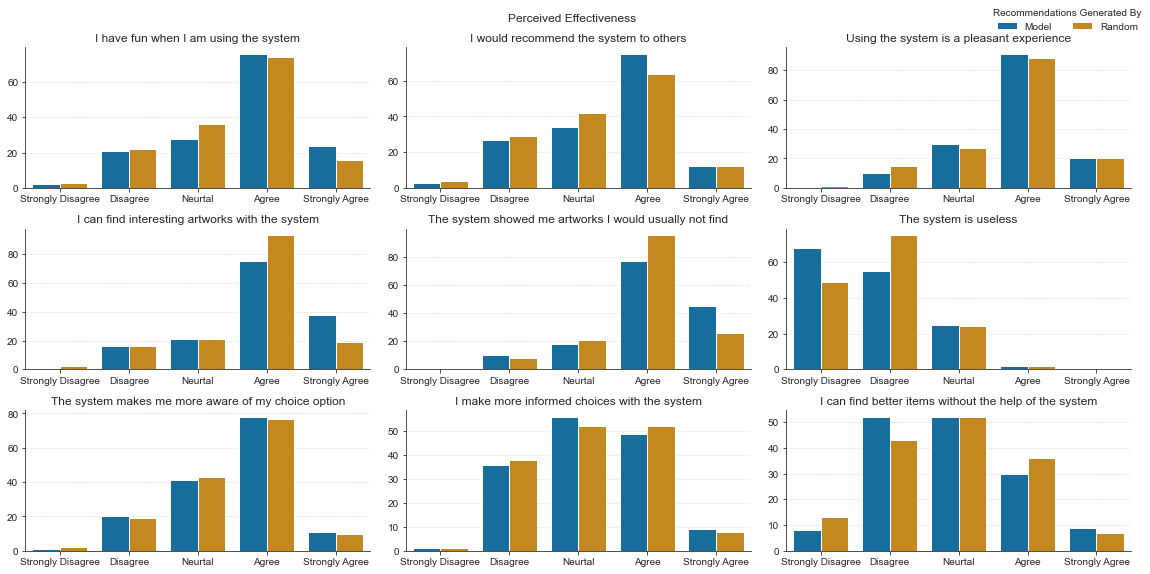

In [80]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (16, 8))
axes = axes.ravel()

for ax, q in zip(axes, questions['effectiveness']):
    p = sns.countplot(
        x = q, 
        data = data_formatted,
        ax = ax, 
        order = likert_mapping['order'],
        hue = 'condition'
    )
    p.set(
        ylabel = '',
        xlabel = '',
        xticklabels = likert_mapping['formatted'],
        title = question_mappings[q]
    )
    p.legend_.remove()
    p.yaxis.grid(True, alpha = 0.5, linestyle = 'dashed')

handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, ['Model', 'Random'], ncol = 2, title = 'Recommendations Generated By', frameon = False)

fig.suptitle('Perceived Effectiveness')
sns.despine()
plt.tight_layout()
# plt.show()
plt.savefig('../plots/post-study/perceived_effectiveness_by_recs.png', dpi = 300)

##### Perceived Quality by recommendation type

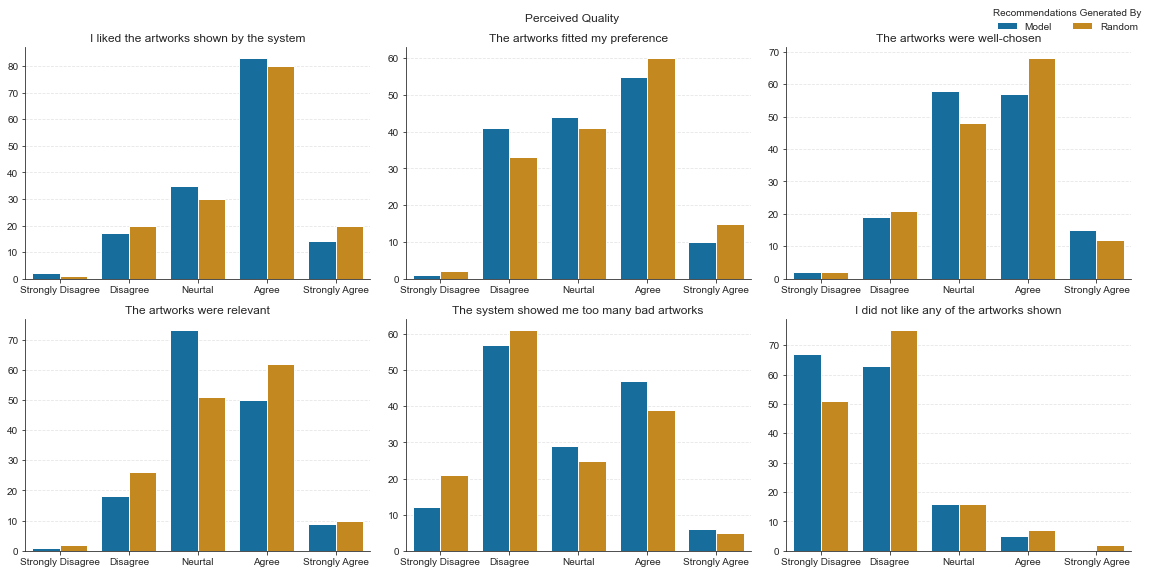

In [81]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 8))
axes = axes.ravel()

for ax, q in zip(axes, questions['quality']):
    p = sns.countplot(
        x = q, 
        data = data_formatted,
        ax = ax, 
        order = likert_mapping['order'],
        hue = 'condition'
    )
    p.set(
        ylabel = '',
        xlabel = '',
        xticklabels = likert_mapping['formatted'],
        title = question_mappings[q]
    )
    p.legend_.remove()
    p.yaxis.grid(True, alpha = 0.5, linestyle = 'dashed')

handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, ['Model', 'Random'], ncol = 2, title = 'Recommendations Generated By', frameon = False)

fig.suptitle('Perceived Quality')
sns.despine()
plt.tight_layout()
# plt.show()
plt.savefig('../plots/post-study/perceived_quality_by_recs.png', dpi = 300)

##### Test Awareness by recommendation type

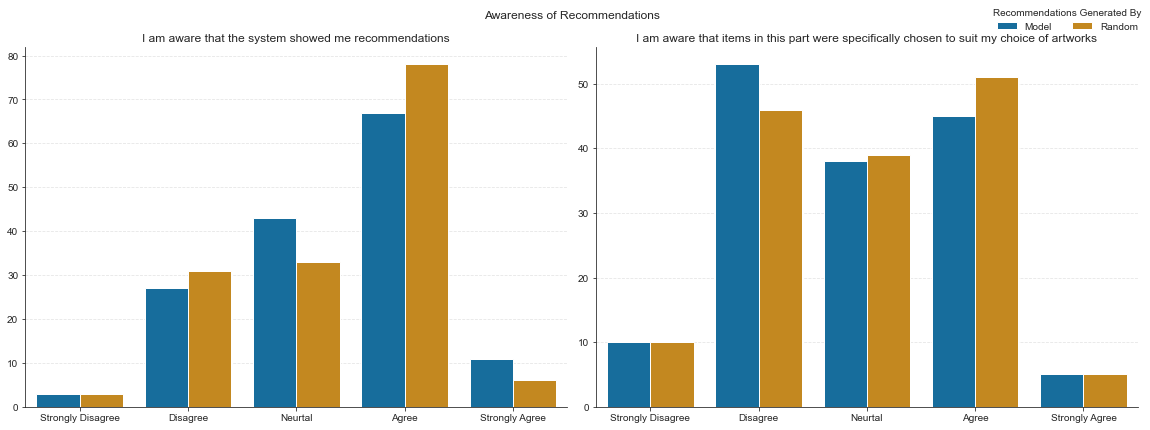

In [82]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))
axes = axes.ravel()

for ax, q in zip(axes, questions['awareness']):
    p = sns.countplot(
        x = q, 
        data = data_formatted,
        ax = ax, 
        order = likert_mapping['order'],
        hue = 'condition'
    )
    p.set(
        ylabel = '',
        xlabel = '',
        xticklabels = likert_mapping['formatted'],
        title = question_mappings[q]
    )
    p.legend_.remove()
    p.yaxis.grid(True, alpha = 0.5, linestyle = 'dashed')

handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, ['Model', 'Random'], ncol = 2, title = 'Recommendations Generated By', frameon = False)

fig.suptitle('Awareness of Recommendations')
sns.despine()
plt.tight_layout()
# plt.show()
plt.savefig('../plots/post-study/test_awareness_by_recs.png', dpi = 300)

#### Perceived Quality by the type of recommendation model used (either meta, image, or concatenated)

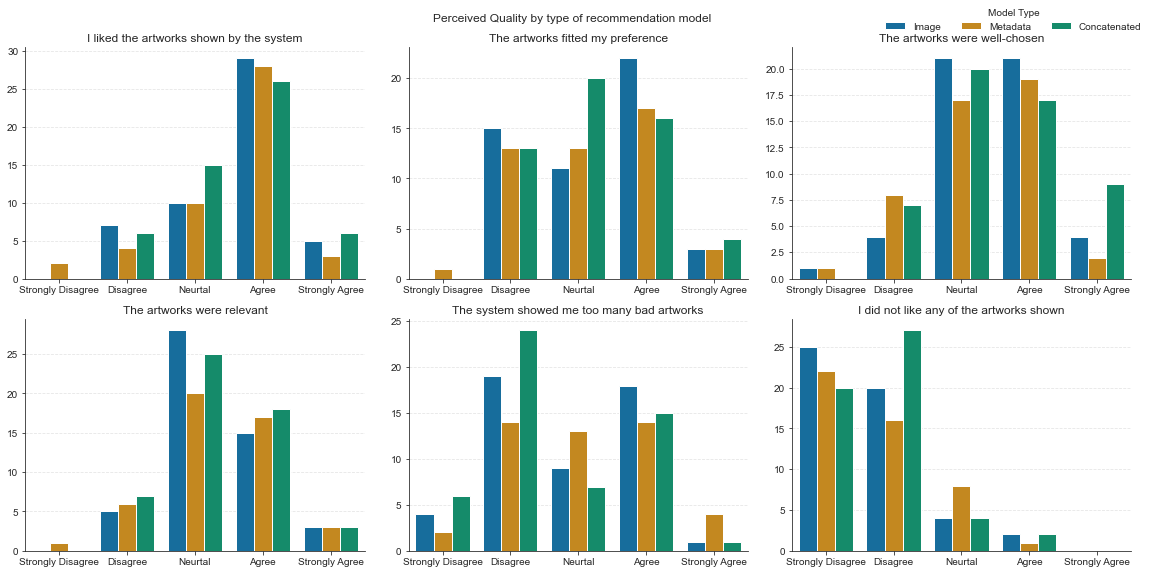

In [83]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 8))
axes = axes.ravel()

for ax, q in zip(axes, questions['quality']):
    p = sns.countplot(
        x = q, 
        data = data_formatted[data_formatted.condition == 'model'],
        ax = ax, 
        order = likert_mapping['order'],
        hue = 'model_type'
    )
    p.set(
        ylabel = '',
        xlabel = '',
        xticklabels = likert_mapping['formatted'],
        title = question_mappings[q]
    )
    p.legend_.remove()
    p.yaxis.grid(True, alpha = 0.5, linestyle = 'dashed')

handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, ['Image', 'Metadata', 'Concatenated'], ncol = 3, title = 'Model Type', frameon = False)

fig.suptitle('Perceived Quality by type of recommendation model')
sns.despine()
plt.tight_layout()
# plt.show()
plt.savefig('../plots/post-study/perceived_quality_by_model_type.png', dpi = 300)

#### Choice Satisfaction by type of recommendation model used

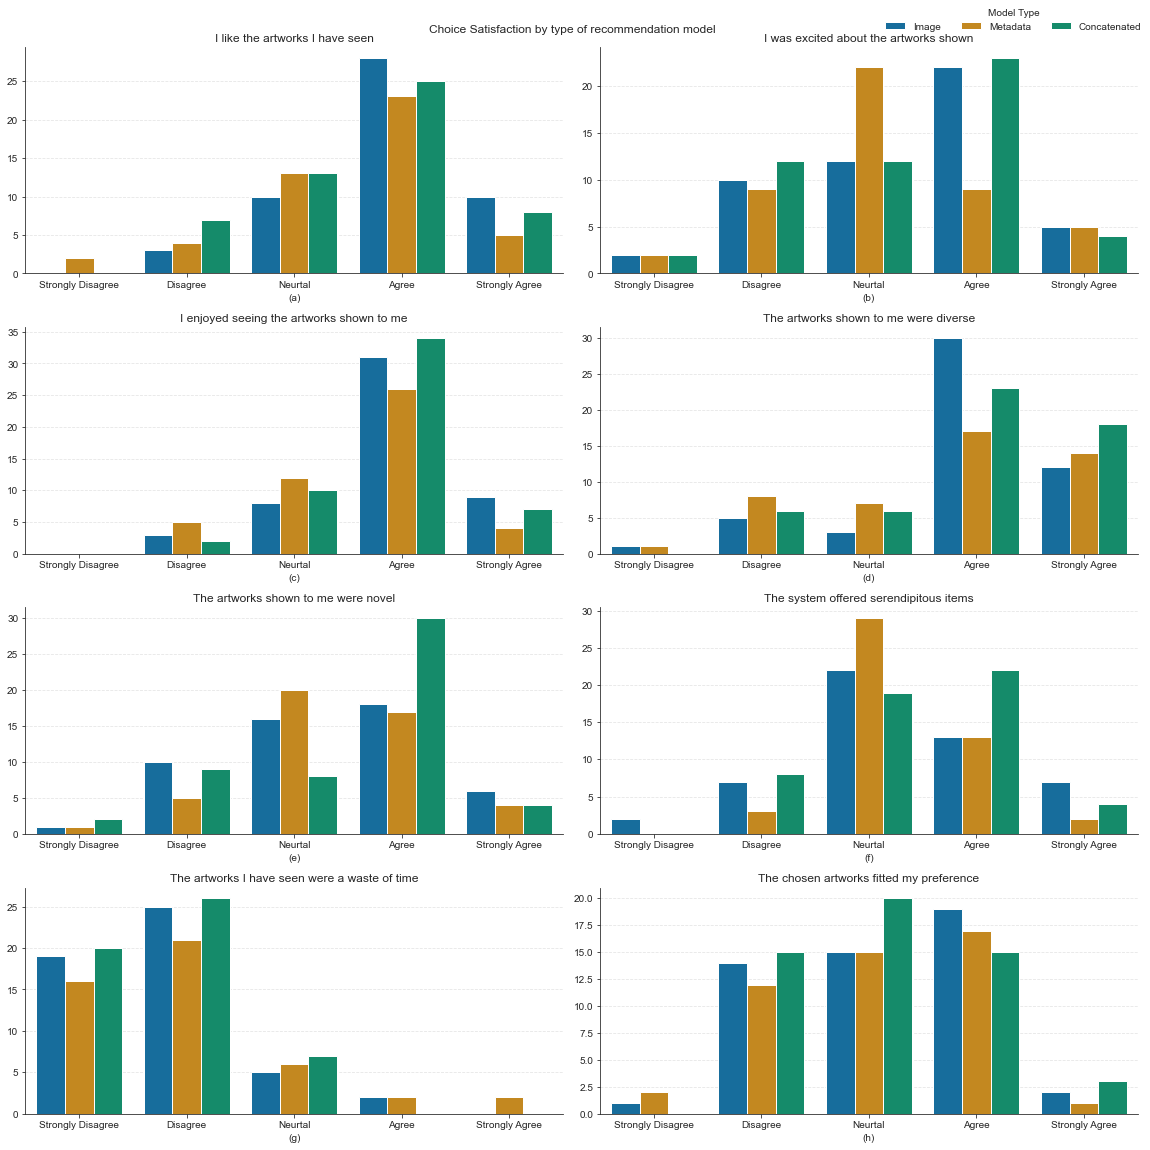

In [93]:
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (16, 16)) # 16, 8
axes = axes.ravel()

for ax, q, caption in zip(axes, questions['satisfaction'], ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']):
    p = sns.countplot(
        x = q, 
        data = data_formatted[data_formatted.condition == 'model'],
        ax = ax, 
        order = likert_mapping['order'],
        hue = 'model_type'
    )
    p.set(
        ylabel = '',
        xlabel = '(' + caption + ')',
        xticklabels = likert_mapping['formatted'],
        title = question_mappings[q]
    )
    p.legend_.remove()
    p.yaxis.grid(True, alpha = 0.5, linestyle = 'dashed')

handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, ['Image', 'Metadata', 'Concatenated'], ncol = 3, title = 'Model Type', frameon = False)

fig.suptitle('Choice Satisfaction by type of recommendation model')
sns.despine()
plt.tight_layout()
# plt.show()
plt.savefig('../plots/post-study/choice_satisfaction_by_model_type.png', dpi = 300)

##### Perceived effectiveness by type of recommendation model

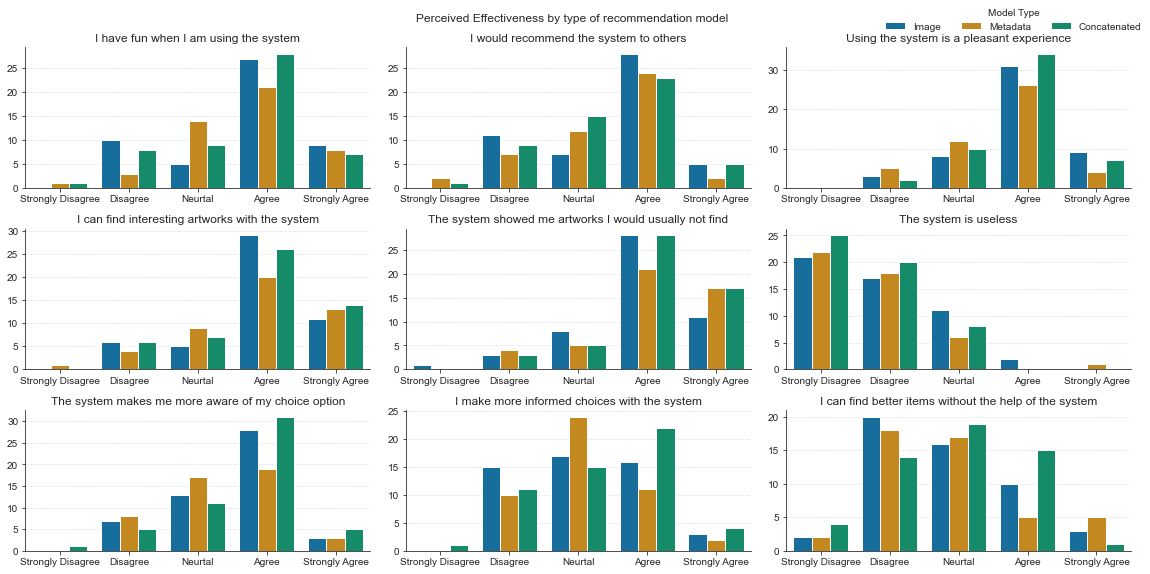

In [53]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (16, 8))
axes = axes.ravel()

for ax, q in zip(axes, questions['effectiveness']):
    p = sns.countplot(
        x = q, 
        data = data_formatted[data_formatted.condition == 'model'],
        ax = ax, 
        order = likert_mapping['order'],
        hue = 'model_type'
    )
    p.set(
        ylabel = '',
        xlabel = '',
        xticklabels = likert_mapping['formatted'],
        title = question_mappings[q]
    )
    p.legend_.remove()
    p.yaxis.grid(True, alpha = 0.5, linestyle = 'dashed')

handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, ['Image', 'Metadata', 'Concatenated'], ncol = 3, title = 'Model Type', frameon = False)

fig.suptitle('Perceived Effectiveness by type of recommendation model')
sns.despine()
plt.tight_layout()
# plt.show()
plt.savefig('../plots/post-study/perceived_effectiveness_by_model_type.png', dpi = 300)

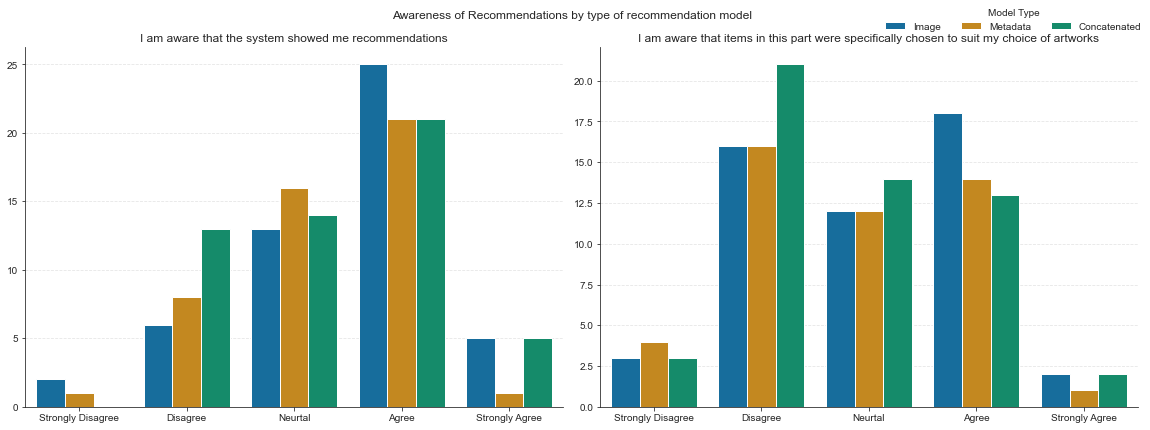

In [54]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))
axes = axes.ravel()

for ax, q in zip(axes, questions['awareness']):
    p = sns.countplot(
        x = q, 
        data = data_formatted[data_formatted.condition == 'model'],
        ax = ax, 
        order = likert_mapping['order'],
        hue = 'model_type'
    )
    p.set(
        ylabel = '',
        xlabel = '',
        xticklabels = likert_mapping['formatted'],
        title = question_mappings[q]
    )
    p.legend_.remove()
    p.yaxis.grid(True, alpha = 0.5, linestyle = 'dashed')

handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, ['Image', 'Metadata', 'Concatenated'], ncol = 3, title = 'Model Type', frameon = False)

fig.suptitle('Awareness of Recommendations by type of recommendation model')
sns.despine()
plt.tight_layout()
# plt.show()
plt.savefig('../plots/post-study/test_awareness_by_model_type.png', dpi = 300)

##### Group the question categories to simplify analysis

In [55]:
for question, parts in questions.items():
    data_formatted[question] = data_formatted[parts].replace(likert_mapping['numerical']).mean(axis = 1).round(decimals = 3)

data_formatted[list(questions.keys())].head()

,satisfaction,effectiveness,quality,awareness,intention,relevant,trust
0,3.222,3.3,3.167,4.5,4.0,3.5,3.2
1,2.444,3.0,2.500,3.0,4.0,3.5,3.2
2,3.333,2.9,2.333,2.0,2.0,1.5,2.8
3,3.222,3.2,2.333,2.0,2.0,1.5,2.8
4,3.889,3.2,2.833,4.0,4.0,2.0,3.2


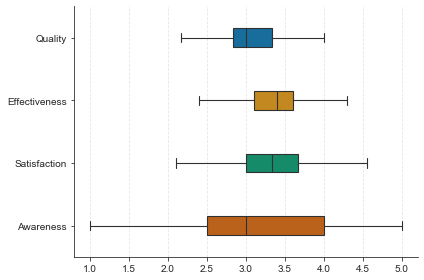

In [56]:
p = sns.boxplot(
    data = data_formatted[[
        'quality', 'effectiveness', 'satisfaction', 'awareness'
    ]],
    orient = 'h',
    width = 0.3,
    linewidth = 1.1,
    notch = False, 
    showfliers = False
)
p.set(
    xlabel = '',
    yticklabels = [
        'Quality', 'Effectiveness', 'Satisfaction', 'Awareness'
    ]
)
p.xaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
p.set_axisbelow(True)
sns.despine()
plt.tight_layout()
plt.show()

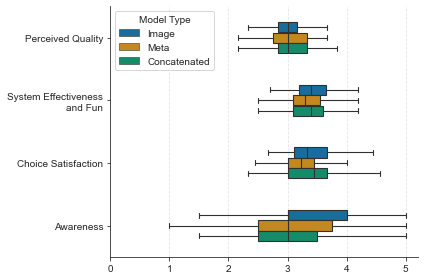

In [57]:
p = sns.boxplot(
    data = data_formatted[data_formatted.model_type != 'random'].melt(
        id_vars = 'model_type',
        value_vars = ['quality', 'effectiveness', 'satisfaction', 'awareness'],
        var_name = 'question',
        value_name = 'score'
    ),
    y = 'question', x = 'score', hue = 'model_type',
    width = 0.5, 
    linewidth = 1.1, 
    notch = False, 
    showfliers = False
)
p.set(
    xlabel = '', 
    ylabel = '',
    yticklabels = ['Perceived Quality', 'System Effectiveness\nand Fun', 'Choice Satisfaction', 'Awareness'],
    xticks = [0, 1, 2, 3, 4, 5]
)
p.xaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
p.set_axisbelow(True)

p.legend_.set_title('Model Type')
for t, l in zip(p.legend_.texts, ['Image', 'Meta', 'Concatenated']):
    t.set_text(l)

sns.despine()
plt.tight_layout()
plt.show()

In [58]:
# test whether there is a statistical difference between model type and the questionnaire groupings
data_formatted[data_formatted.model_type != 'random'].melt(
    id_vars = 'model_type',
    value_vars = ['quality', 'effectiveness', 'satisfaction', 'awareness'],
    var_name = 'question',
    value_name = 'score'
)

,model_type,question,score
0,image,quality,3.167
1,meta,quality,2.333
2,image,quality,2.833
3,concatenated,quality,3.333
4,concatenated,quality,3.167
...,...,...,...
599,meta,awareness,4.000
600,image,awareness,2.000
601,meta,awareness,3.000
602,meta,awareness,3.500


In [59]:
# data_formatted[data_formatted.model_type == 'image'][['quality', 'effectiveness', 'satisfaction', 'awareness']]
for question in ['quality', 'effectiveness', 'satisfaction', 'awareness']:
    stat, p = sp.kruskal(
        data_formatted[data_formatted.model_type == 'image'][question].tolist(),
        data_formatted[data_formatted.model_type == 'meta'][question].tolist(),
        data_formatted[data_formatted.model_type == 'concatenated'][question].tolist()
    )

    if p <= 0.05:
        print('Significant difference in', question)

In [60]:
data_formatted = data_formatted.merge(
    right = pd.read_csv('../data/users.csv'), 
    on = 'user_id'
).drop(columns = 'condition_y').rename(columns = {'condition_x': 'condition'})

domain_knowledge_mappings = {
    'art_knowledge': ['Novice', 'Some knowledge', 'Knowledgeable', 'Expert'],
    'art_knowledge_order': ['novice', 'some', 'knowledgeable', 'expert'],
    'museum_visits': ['Most Days', 'At least once a week', 'At least once a month', 'Every two or three months', 'Once a year', 'First time'],
    'museum_visits_order': ['most days', 'once a week', 'once a month', 'every two or three months', 'once a year', 'first time'],
    'view_collections': ['Most Days', 'At least once a week', 'At least once a month', 'Every two or three months', 'Once a year', 'First time'],
    'view_collections_order': ['most days', 'once a week', 'once a month', 'every two or three months', 'once a year', 'first time'],
    'physical_visits': ['Every six months', 'Once a year', 'Every two or three years', 'Every four or five years', 'Six years or longer', 'Never'],
    'physical_visits_order': ['once every 6 months', 'once a year', 'two or three years', 'four or five years', 'six years or longer', 'never'],
    'art_knowledge_title': 'Art Knowledge',
    'museum_visits_title': 'Museum Visits',
    'view_collections_title': 'View Collections',
    'physical_visits_title': 'Physical Visits'
}

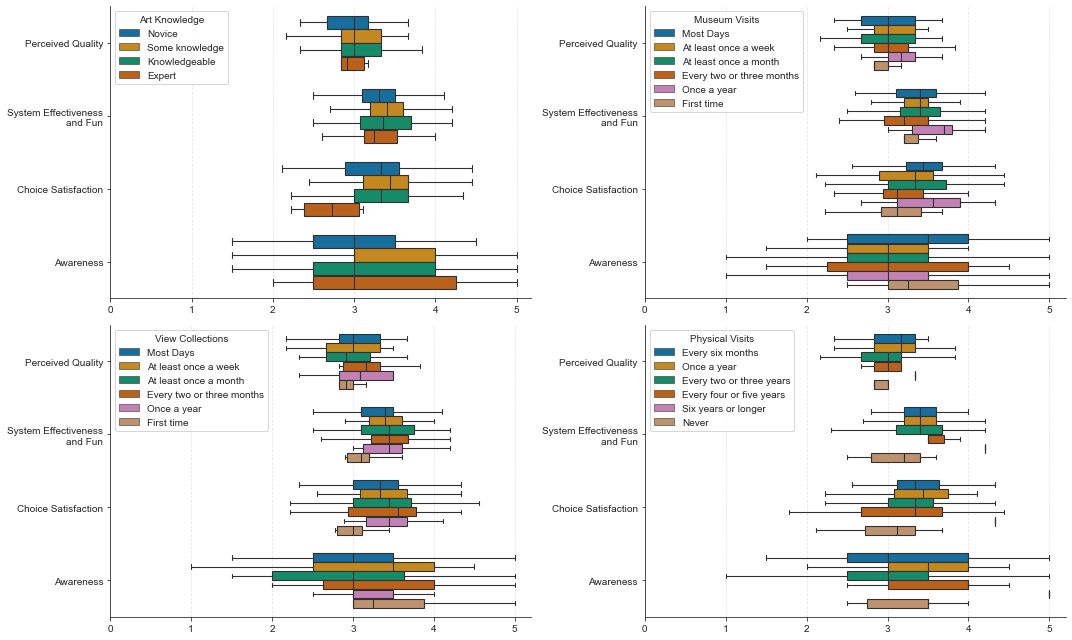

In [61]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 9))
axes = axes.ravel()

for ax, demo in zip(axes, ['art_knowledge', 'museum_visits', 'view_collections', 'physical_visits']):
    p = sns.boxplot(
        data = data_formatted[data_formatted.model_type != 'random'].melt(
            id_vars = demo,
            value_vars = ['quality', 'effectiveness', 'satisfaction', 'awareness'],
            var_name = 'question',
            value_name = 'score'
        ),
        y = 'question', x = 'score', hue = demo,
        width = 0.75, 
        linewidth = 1.1, 
        notch = False, 
        showfliers = False, 
        ax = ax 
    )
    p.set(
        xlabel = '', 
        ylabel = '',
        yticklabels = ['Perceived Quality', 'System Effectiveness\nand Fun', 'Choice Satisfaction', 'Awareness'],
        xticks = [0, 1, 2, 3, 4, 5]
    )
    p.xaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
    p.set_axisbelow(True)

    p.legend_.set_title(domain_knowledge_mappings[demo + '_title'])
    for t, l in zip(p.legend_.texts, domain_knowledge_mappings[demo]):
        t.set_text(l)

sns.despine()
plt.tight_layout()
plt.show()

In [62]:
data_formatted.columns

Index(['choice_satisfaction_one', 'choice_satisfaction_two',
       'choice_satisfaction_three', 'choice_satisfaction_four',
       'choice_satisfaction_five', 'choice_satisfaction_six',
       'choice_satisfaction_seven', 'choice_satisfaction_eight',
       'choice_satisfaction_nine', 'perceived_effectiveness_one',
       'perceived_effectiveness_two', 'perceived_effectiveness_three',
       'perceived_effectiveness_four', 'perceived_effectiveness_five',
       'perceived_effectiveness_six', 'perceived_effectiveness_seven',
       'perceived_effectiveness_eight', 'perceived_effectiveness_nine',
       'perceived_effectiveness_ten', 'perceived_quality_one',
       'perceived_quality_two', 'perceived_quality_three',
       'perceived_quality_four', 'perceived_quality_five',
       'perceived_quality_six', 'test_awareness_one', 'test_awareness_two',
       'intention', 'relevant_one', 'relevant_two', 'relevant_three',
       'relevant_four', 'trust_one', 'trust_two', 'trust_three', 'trus

In [63]:
data_formatted.to_csv('../data/merged_user_post_study.csv', index = False)

#### General questions: Relevance

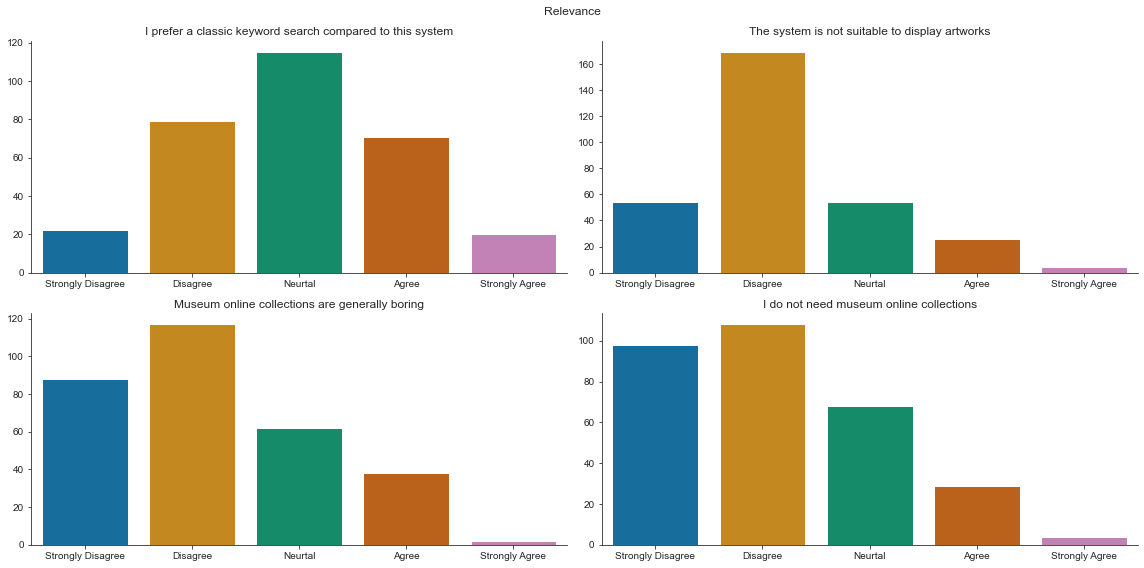

In [64]:
# Create a larger multi-plot for the bigger question groupings, i.e., satisfaction (5x2)
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 8))
axes = axes.ravel()

for ax, q in zip(axes, questions['relevant']):
    p = sns.countplot(
        x = q, data = post_study, ax = ax, 
        order = likert_mapping['order']
    )
    p.set(
        ylabel = '',
        xlabel = '',
        xticklabels = likert_mapping['formatted'],
        title = question_mappings[q]
    )

fig.suptitle('Relevance')
sns.despine()
plt.tight_layout()
plt.savefig('../plots/post-study/relevant.png', dpi = 300)
# plt.show()

In [66]:
data_formatted.columns

Index(['choice_satisfaction_one', 'choice_satisfaction_two',
       'choice_satisfaction_three', 'choice_satisfaction_four',
       'choice_satisfaction_five', 'choice_satisfaction_six',
       'choice_satisfaction_seven', 'choice_satisfaction_eight',
       'choice_satisfaction_nine', 'perceived_effectiveness_one',
       'perceived_effectiveness_two', 'perceived_effectiveness_three',
       'perceived_effectiveness_four', 'perceived_effectiveness_five',
       'perceived_effectiveness_six', 'perceived_effectiveness_seven',
       'perceived_effectiveness_eight', 'perceived_effectiveness_nine',
       'perceived_effectiveness_ten', 'perceived_quality_one',
       'perceived_quality_two', 'perceived_quality_three',
       'perceived_quality_four', 'perceived_quality_five',
       'perceived_quality_six', 'test_awareness_one', 'test_awareness_two',
       'intention', 'relevant_one', 'relevant_two', 'relevant_three',
       'relevant_four', 'trust_one', 'trust_two', 'trust_three', 'trus

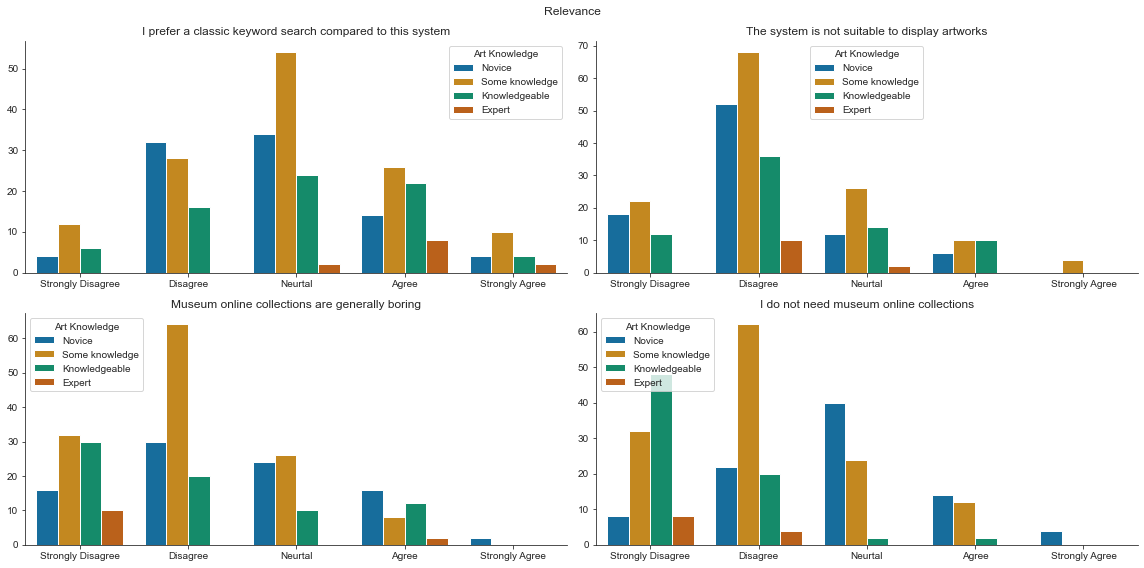

In [68]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 8))
axes = axes.ravel()

for ax, q in zip(axes, questions['relevant']):
    p = sns.countplot(
        x = q, data = data_formatted, ax = ax, 
        order = likert_mapping['order'],
        hue = 'art_knowledge'
    )
    p.set(
        ylabel = '',
        xlabel = '',
        xticklabels = likert_mapping['formatted'],
        title = question_mappings[q]
    )
    p.legend_.set_title(domain_knowledge_mappings['art_knowledge_title'])
    for t, l in zip(p.legend_.texts, domain_knowledge_mappings['art_knowledge']):
        t.set_text(l)

fig.suptitle('Relevance')
sns.despine()
plt.tight_layout()
# plt.savefig('../plots/post-study/relevant.png', dpi = 300)
plt.show()

#### General questions: trust


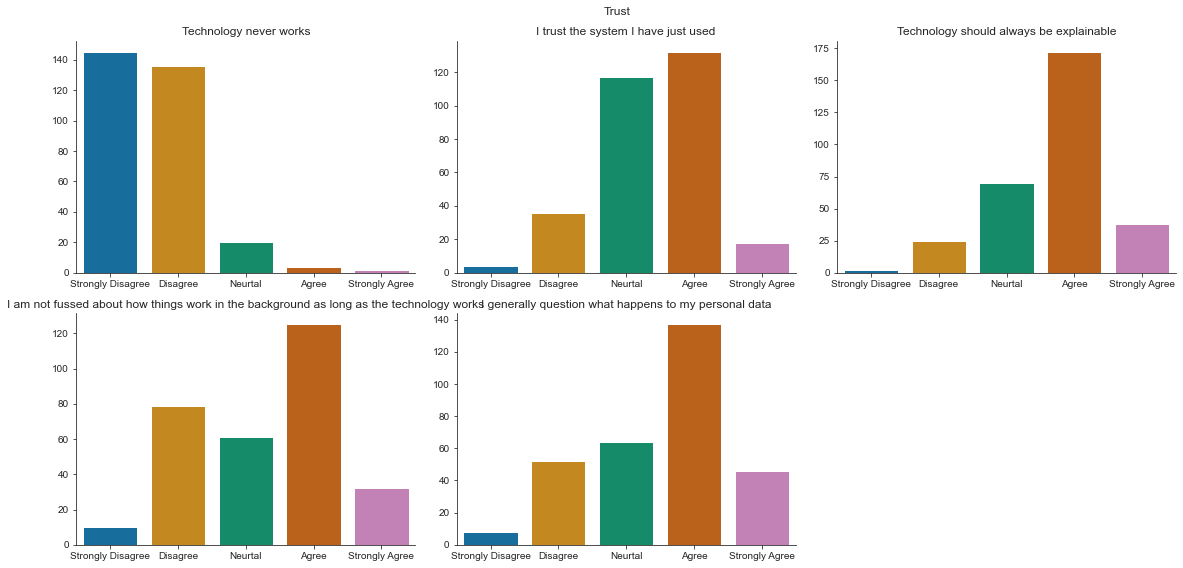

In [36]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 8))
# print(axes.shape)
fig.delaxes(axes[1][2])
axes = axes.ravel()

for ax, q in zip(axes, questions['trust']):
    p = sns.countplot(
        x = q, data = post_study, ax = ax, 
        order = likert_mapping['order']
    )
    p.set(
        ylabel = '',
        xlabel = '',
        xticklabels = likert_mapping['formatted'],
        title = question_mappings[q]
    )

fig.suptitle('Trust')
sns.despine()
plt.tight_layout()
plt.savefig('../plots/post-study/trust.png', dpi = 300)
# plt.show()

In [30]:
post_study['trust_one'].value_counts()



strongly disagree    145
disagree             136
neutral               20
agree                  4
strongly agree         2
Name: trust_one, dtype: int64

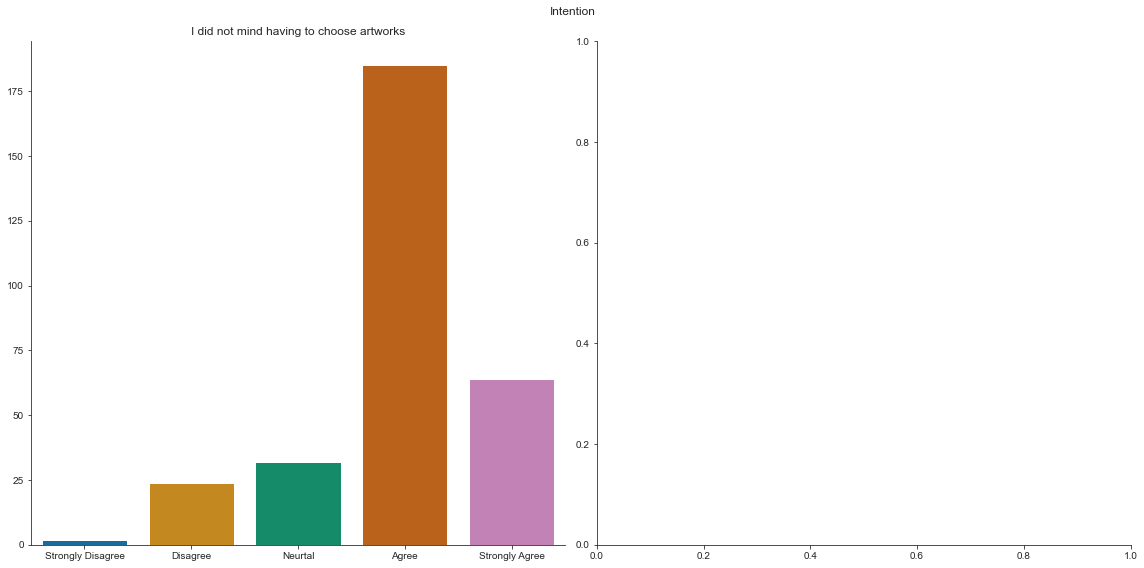

In [65]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 8))
axes = axes.ravel()

for ax, q in zip(axes, questions['intention']):
    p = sns.countplot(
        x = q, data = post_study, ax = ax, 
        order = likert_mapping['order']
    )
    p.set(
        ylabel = '',
        xlabel = '',
        xticklabels = likert_mapping['formatted'],
        title = question_mappings[q]
    )

fig.suptitle('Intention')
sns.despine()
plt.tight_layout()
plt.savefig('../plots/post-study/intention.png', dpi = 300)
# plt.show()

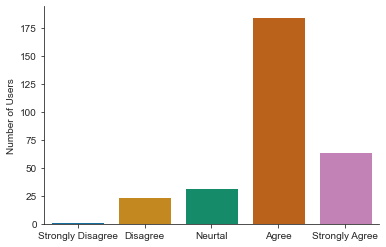

In [99]:
p = sns.countplot(
    x = 'intention', data = post_study,
    order = likert_mapping['order']
)
p.set(
    xlabel = '',
    ylabel = 'Number of Users',
    xticklabels = likert_mapping['formatted']
)
sns.despine()